In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
import seaborn as sns
from tqdm import tqdm

from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies

pd.set_option("display.max_rows", 50)

### All Cryptocurrencies information

In [2]:
df_cryptopairs = Cryptocurrencies().find_crypto_pairs()
df_cryptopairs

Connected to the CoinBase Pro API.
Extended Output is False, returning reduced dataset.


,id,display_name,fx_stablecoin,max_slippage_percentage,status
0,IMX-USDT,IMX/USDT,False,0.03000000,online
1,ADA-EUR,ADA/EUR,False,0.03000000,online
2,ETH-BTC,ETH/BTC,False,0.03000000,online
3,FET-USDT,FET/USDT,False,0.03000000,online
4,ORN-USD,ORN/USD,False,0.03000000,online
...,...,...,...,...,...
550,COTI-USD,COTI/USD,False,0.03000000,online
551,CTSI-USD,CTSI/USD,False,0.03000000,online
552,SOL-USD,SOL/USD,False,0.03000000,online
553,MPL-USD,MPL/USD,False,0.03000000,online


### Top K Market Value

In [3]:
start_data = '2022-01-01-00-00'
end_date = '2022-06-30-00-00'

frequency = 60 * 60 * 24

idToMkt = {}

for id in df_cryptopairs['id']:
    try:
        data = HistoricalData(id, frequency, start_data, end_date).retrieve_data()
    except:
        continue
    avgVolume = data['volume'].mean()
    avgPrice = data['close'].mean()
    idToMkt[id] = avgVolume * avgPrice

df_idToMkt = pd.DataFrame(idToMkt, index = ['mkt']).T.sort_values(by='mkt', ascending=False)

df_idToMkt.head(10)

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'IMX-USDT' found at the CoinBase Pro API, continuing to extraction.
Retrieved Data from Coinbase Pro API.
Returning data.
Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'ADA-EUR' found at the CoinBase Pro API, continuing to extraction.
Retrieved Data from Coinbase Pro API.
Returning data.
Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'ETH-BTC' found at the CoinBase Pro API, continuing to extraction.
Retrieved Data from Coinbase Pro API.
Returning data.
Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is avail

,mkt
WLUNA-USD,3.318065e+12
WLUNA-USDT,2.406700e+11
WLUNA-EUR,9.707741e+10
WLUNA-GBP,2.526987e+10
BTC-USD,7.015202e+08
ETH-USD,5.422595e+08
SOL-USD,1.536598e+08
AVAX-USD,9.233364e+07
ADA-USD,9.079091e+07
SHIB-USD,8.376272e+07


In [4]:
select_cryptopairs = df_idToMkt.index[4: 9]
# select_cryptopairs = select_cryptopairs.drop('USDT-USD')
select_cryptopairs

Index(['BTC-USD', 'ETH-USD', 'SOL-USD', 'AVAX-USD', 'ADA-USD'], dtype='object')

### Construct DataBase

In [2]:
db_path = Path("./crypto.h5")
db_path

WindowsPath('crypto.h5')

In [6]:
start_data = '2022-01-01-00-00'
end_date = '2022-06-30-00-00'


frequency = 60 * 60

df_all = pd.DataFrame()

for id in select_cryptopairs:
    df = pd.DataFrame()
    try:
        df = HistoricalData(id, frequency, start_data, end_date).retrieve_data().reset_index()
    except:
        continue

    df['id'] = id
    df = df.set_index(['time', 'id'])

    df_all = df_all.append(df)


Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2022-01-01T00:00:00
Provisional End: 2022-01-13T12:00:00
Data for chunk 1 of 15 extracted
Provisional Start: 2022-01-13T12:00:00
Provisional End: 2022-01-26T00:00:00
Data for chunk 2 of 15 extracted
Provisional Start: 2022-01-26T00:00:00
Provisional End: 2022-02-07T12:00:00
Data for chunk 3 of 15 extracted
Provisional Start: 2022-02-07T12:00:00
Provisional End: 2022-02-20T00:00:00
Data for chunk 4 of 15 extracted
Provisional Start: 2022-02-20T00:00:00
Provisional End: 2022-03-04T12:00:00
Data for chunk 5 of 15 extracted
Provisional Start: 2022-03-04T12:00:00
Provisional End: 2022-03-17T00:00:00
Data for chunk 6 of 15 extracted
Provisional Start: 2022-03-17T00:00:00
Provisional End: 2022-03-29T12:00:00
Data for chunk 7 of 15 ext

In [7]:
with pd.HDFStore(db_path) as store:
    store.put(f"Min{int(frequency/60)}", df_all)

db_path.stat().st_size

997672

### EDA

In [3]:
frequency = 60 * 60
df_all = pd.read_hdf(db_path, f"Min{int(frequency/60)}")

df_ts = df_all['close'].unstack()
df_ts.columns

Index(['ADA-USD', 'AVAX-USD', 'BTC-USD', 'ETH-USD', 'SOL-USD'], dtype='object', name='id')

In [4]:
df_ts_ret = df_ts[['BTC-USD', 'ETH-USD']]

df_ts_ret = df_ts_ret.pct_change().dropna()
df_ts_ret

id,BTC-USD,ETH-USD
time,,
2022-01-01 02:00:00,0.000592,0.000999
2022-01-01 03:00:00,-0.000097,-0.001336
2022-01-01 04:00:00,-0.002195,-0.004322
2022-01-01 05:00:00,0.010422,0.007589
2022-01-01 06:00:00,-0.004472,-0.006605
...,...,...
2022-06-29 20:00:00,-0.000288,-0.007578
2022-06-29 21:00:00,0.003886,0.004106
2022-06-29 22:00:00,-0.004126,-0.004278


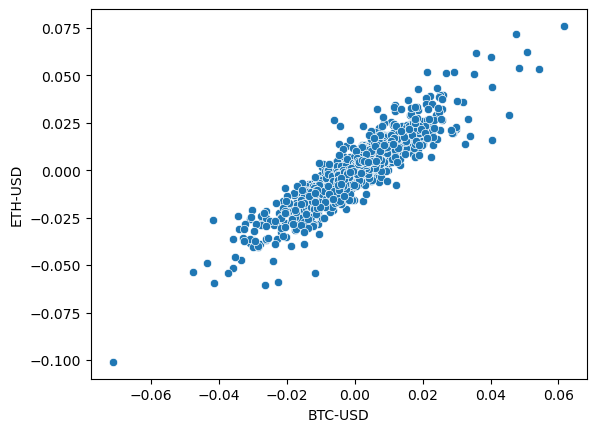

In [9]:
sns.scatterplot(x = df_ts_ret['BTC-USD'], y = df_ts_ret['ETH-USD'])

In [11]:
from sklearn.decomposition import PCA


X = df_ts_ret.values
X = X - X.mean(axis=1)

pca = PCA(n_components=2)
pca.fit(df_ts_ret)



PCA(n_components=2)

In [19]:
pca.components_

array([[-0.60007234, -0.79994574],
       [ 0.79994574, -0.60007234]])

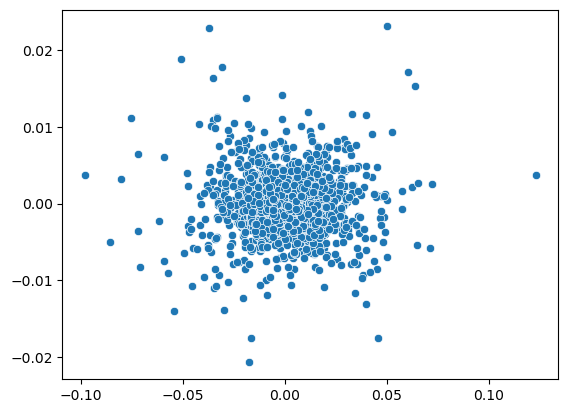

In [18]:
X_pca = pca.fit_transform(df_ts_ret)

sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1])

<AxesSubplot:xlabel='id', ylabel='id'>

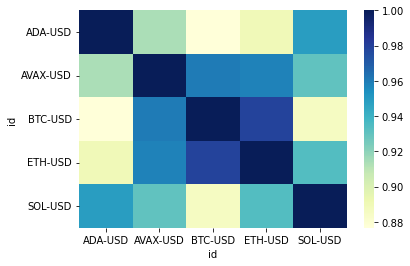

In [9]:
sns.heatmap(df_ts.corr(), cmap="YlGnBu")

<AxesSubplot:xlabel='time', ylabel='BTC-USD'>

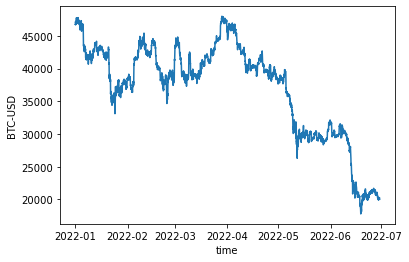

In [10]:
sns.lineplot(data = df_ts['BTC-USD'])